# E03

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [1]:
import torch

In [2]:
import random
random.seed(42)

words = open('../names.txt','r').read().splitlines()

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

words_tr = words[:n1]
words_dev = words[n1:n2]
words_te = words[n2:]

In [3]:
chars = sorted(list(set(''.join(words_tr))))
len(chars)

26

In [4]:
ctoi = {c : i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0

In [5]:
itoc = {i:c for c,i in ctoi.items()}

In [6]:
num_chars = len(ctoi.keys())
num_chars

27

In [7]:
stoi = {}
for i0,c0 in sorted(itoc.items(), key=lambda kv: kv[0]):
    for i1,c1 in sorted(itoc.items(), key=lambda kv: kv[0]):
        #print((i0*num_chars) + i1,c0,c1)
        stoi[(c0,c1)] = (i0*num_chars) + i1

In [8]:
def build_dataset(words):
    xs,ys = [],[]
    
    for word in words:
        chs = '..' + word + '.'
        for ch1,ch2,ch3 in zip(chs,chs[1:],chs[2:]):
            ix1 = stoi[ch1,ch2]
            ix2 = ctoi[ch3]
            xs.append(ix1)
            ys.append(ix2)
    
    # prefer to use torch.tensor instead of torch.Tensor
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    num = xs.nelement()
    print(f'number of examples: {num}')   

    return xs, ys

In [9]:
Xtr,Ytr=build_dataset(words_tr)
Xdev,Ydev=build_dataset(words_dev)
Xte,Yte=build_dataset(words_te)

number of examples: 182625
number of examples: 22655
number of examples: 22866


In [10]:
import torch.nn.functional as F

In [11]:
rege = torch.linspace(-4,1,200)
regs = 10**rege

loss_tr = []
loss_dev = []
loss_reg = [] #keep track of the loss we are adding from the regularization
for reg in regs:
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((num_chars*num_chars,num_chars), generator=g, requires_grad=True) #single layer of 27 neurons each getting 27x27 inputs
    for k in range(400):
        xs, ys = Xtr, Ytr
        xenc = F.one_hot(xs, num_classes = num_chars*num_chars).float()
        logits = xenc@W #log-counts
        counts = logits.exp() # exponentiate the logits to get fake counts
        probs = counts/counts.sum(1,keepdims=True)
        
        loss_1 = (-(probs[torch.arange(xs.nelement()),ys]).log()).mean()
        loss_2 = reg*(W**2).mean() #regularization loss
        
        loss = loss_1 + loss_2
    
        # if k%40==0: print(loss.item())
        
        #backward pass
        W.grad = None #More efficient than setting to zero directly. Lack of gradient is interpreted as zero by PyTorch
        loss.backward()
        
        #update
        W.data += -4*50 * W.grad    

    loss_tr.append(loss_1.item())
    loss_reg.append(loss_2.item())
    
    xs, ys = Xdev, Ydev
    xenc = F.one_hot(xs, num_classes = num_chars*num_chars).float()
    logits = xenc@W #log-counts
    counts = logits.exp() # exponentiate the logits to get fake counts
    probs = counts/counts.sum(1,keepdims=True)
    loss = (-(probs[torch.arange(xs.nelement()),ys]).log()).mean()
    loss_dev.append(loss.item())

    #print(reg.item(), loss_tr[-1], loss_dev[-1])
print('Done!')

Done!


In [12]:
import pandas as pd
import numpy as np

In [13]:
df = pd.DataFrame({'rege': rege, 'reg': regs, 'loss_tr':loss_tr, 'loss_dev': loss_dev })
df.head()

,rege,reg,loss_tr,loss_dev
0,-4.000000,0.000100,2.283918,2.248096
1,-3.974874,0.000106,2.224400,2.251100
2,-3.949749,0.000112,2.335932,2.280850
3,-3.924623,0.000119,2.228556,2.264807
4,-3.899498,0.000126,2.297669,2.255722


<Axes: xlabel='rege'>

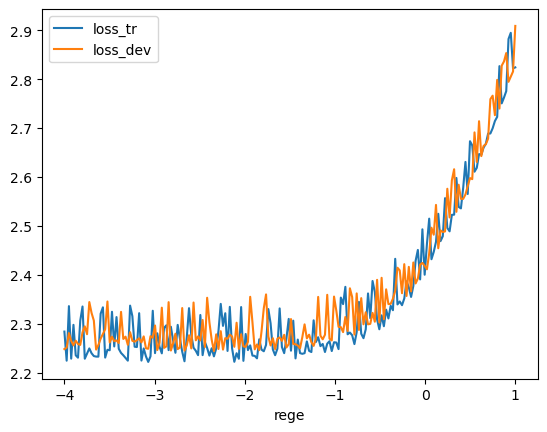

In [14]:
(df.set_index('rege')
 [['loss_tr','loss_dev']]
 .plot()
)

Let's identify the regularization that leads to the lowest loss on the dev set. 

In [15]:
df.loss_dev.idxmin(), df.loss_dev.min()

(66, 2.24414324760437)

In [16]:
df.iloc[df.loss_dev.idxmin(), :]

rege       -2.341709
reg         0.004553
loss_tr     2.233218
loss_dev    2.244143
Name: 66, dtype: float64

Retrain with this best value of regularization

In [17]:
10**(rege[df.loss_dev.idxmin()].item())

0.004552933843974289

In [18]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((num_chars*num_chars,num_chars), generator=g, requires_grad=True) #single layer of 27 neurons each getting 27x27 inputs
reg = 10**(rege[df.loss_dev.idxmin()].item())
for k in range(400):
    xs, ys = Xtr, Ytr
    xenc = F.one_hot(xs, num_classes = num_chars*num_chars).float()
    logits = xenc@W #log-counts
    counts = logits.exp() # exponentiate the logits to get fake counts
    probs = counts/counts.sum(1,keepdims=True)
    
    loss_1 = (-(probs[torch.arange(xs.nelement()),ys]).log()).mean()
    loss_2 = reg*(W**2).mean() #regularization loss
    
    loss = loss_1 + loss_2

    # if k%40==0: print(loss.item())
    
    #backward pass
    W.grad = None #More efficient than setting to zero directly. Lack of gradient is interpreted as zero by PyTorch
    loss.backward()
    
    #update
    W.data += -4*50 * W.grad
print(loss_1.item(), loss_2.item(), loss.item())    

2.2332184314727783 0.006634071934968233 2.2398524284362793


Finally let's evaluate the loss on the test set

In [19]:
xs, ys = Xte, Yte
xenc = F.one_hot(xs, num_classes = num_chars*num_chars).float()
logits = xenc@W #log-counts
counts = logits.exp() # exponentiate the logits to get fake counts
probs = counts/counts.sum(1,keepdims=True)
loss = (-(probs[torch.arange(xs.nelement()),ys]).log()).mean()
print(loss.item())

2.2439746856689453
